<a href="https://colab.research.google.com/github/dwarfy35/deep_learning2/blob/main/FontGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab import drive
from torch.autograd import grad

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, img_size):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.img_size = img_size

        self.model = nn.Sequential(
            nn.Linear(z_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            #nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            #nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, img_size * img_size),
            nn.Tanh()
        )

    def forward(self, z_s, z_c):
        z = torch.cat([z_s, z_c], dim=1)
        img = self.model(z)
        return img.view(img.size(0), 1, self.img_size, self.img_size)

class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size * img_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity


In [3]:
npz_file = '/content/gdrive/My Drive/character_font.npz'

class NPZDataset(Dataset):
    def __init__(self, npz_file, transform=None, filter_label=None, num_samples=None):
        # Load the data from the .npz file
        data = np.load(npz_file)
        self.images = data['images']
        self.labels = data['labels']
        self.transform = transform

        # Filter by label if specified
        if filter_label is not None:
            # Find indices of the desired label
            label_indices = np.where(self.labels == filter_label)[0]

            # If num_samples is specified, limit the number of samples
            if num_samples is not None:
                label_indices = label_indices[:num_samples]

            # Filter images and labels
            self.images = self.images[label_indices]
            self.labels = self.labels[label_indices]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get the image and label for the given index
        image = self.images[idx]
        label = self.labels[idx]

        # Reshape the image to add a channel dimension
        image = image[np.newaxis, ...]  # Add channel dimension at the beginning

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Convert to PyTorch tensor if necessary
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [4]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(real_samples.size(0), 1, device=real_samples.device)
    gradients = grad(outputs=d_interpolates, inputs=interpolates,
                     grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [8]:
def displayGeneratedImage(class_index, generator, z_dim, num_classes, device='cuda'):
    """
    Generates and displays an image for a given class using the generator.

    Args:
        class_index (int): Index of the character class to generate (0 to num_classes - 1).
        generator (nn.Module): Pre-trained generator model.
        z_dim (int): Dimension of the style vector.
        num_classes (int): Number of character classes.
        device (str): Device for computation ('cuda' or 'cpu').
    """
    # Ensure the class index is valid
    if not (0 <= class_index < num_classes):
        raise ValueError(f"Invalid class_index: {class_index}. Must be in range [0, {num_classes - 1}].")

    # Create the one-hot vector for the class
    z_c = torch.zeros(1, num_classes, device=device)
    z_c[0, class_index] = 1  # Set the desired class

    # Create the random style vector
    z_s = torch.randn(1, z_dim, device=device)

    # Concatenate the style and class vectors
    z = torch.cat((z_s, z_c), dim=1)

    # Generate the image
    with torch.no_grad():
        generated_img = generator(z_s,z_c).cpu().numpy()[0, 0]  # Extract the first batch and first channel

    # Rescale the image from [-1, 1] to [0, 255]
    generated_img = np.rot90(generated_img, k=-1)
    generated_img = np.uint8(np.interp(generated_img, (-1, 1), (0, 255)))

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(generated_img, cmap='gray')
    plt.axis("off")
    plt.title(f"Generated Image for Class {class_index}")
    plt.show()


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

#dataset = NPZDataset(npz_file, transform=transform)

<ipython-input-3-44dfbe2328dd>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


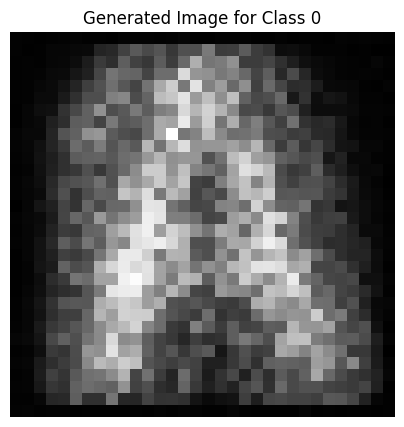

Epoch [1/100], D_loss: -7.424796104431152, G_loss: -5.698206424713135


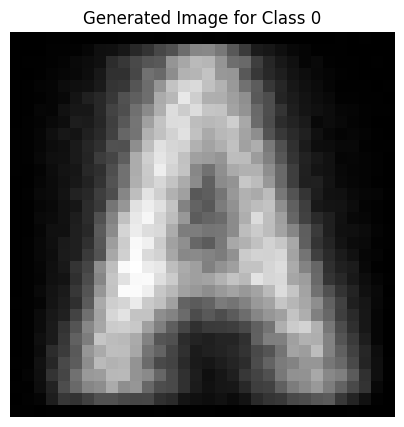

Epoch [2/100], D_loss: -19.574512481689453, G_loss: -0.7062200903892517


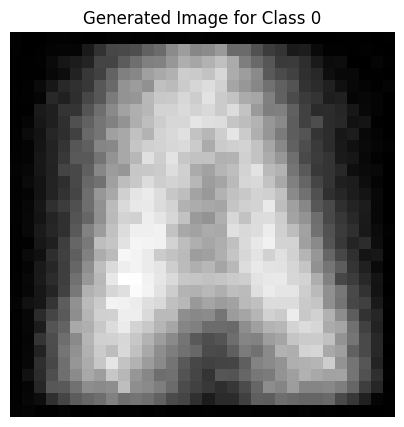

Epoch [3/100], D_loss: -16.038949966430664, G_loss: -2.8377342224121094


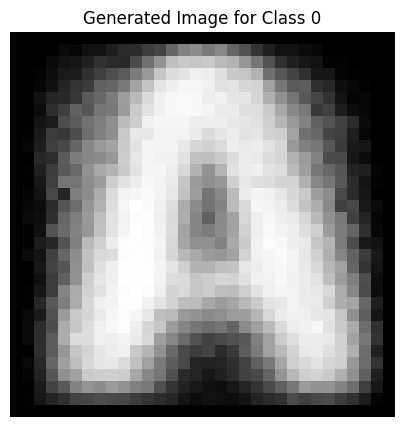

Epoch [4/100], D_loss: -14.612855911254883, G_loss: 0.5303208231925964


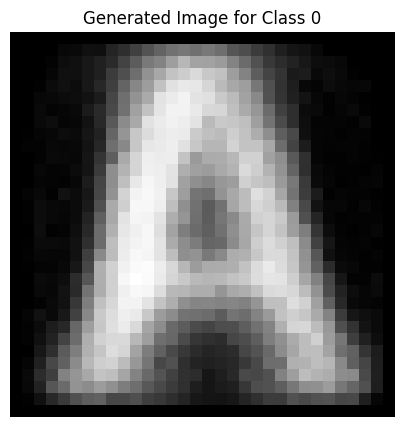

Epoch [5/100], D_loss: -12.665494918823242, G_loss: -3.729381799697876


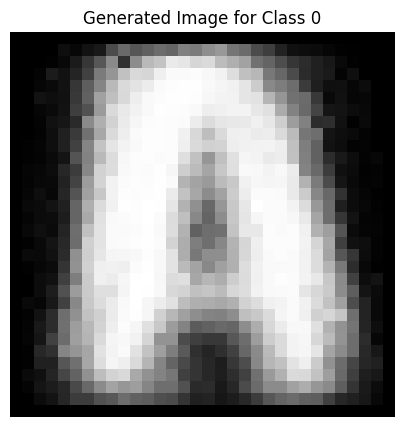

Epoch [6/100], D_loss: -9.725297927856445, G_loss: -4.14518928527832


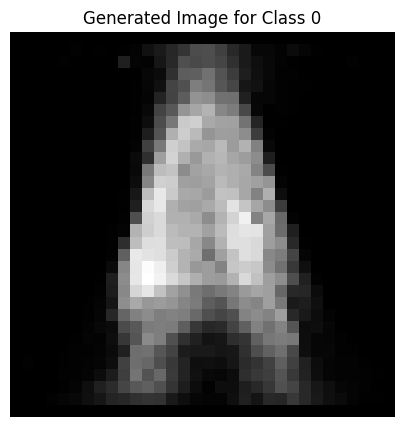

Epoch [7/100], D_loss: -10.947006225585938, G_loss: -3.3117475509643555


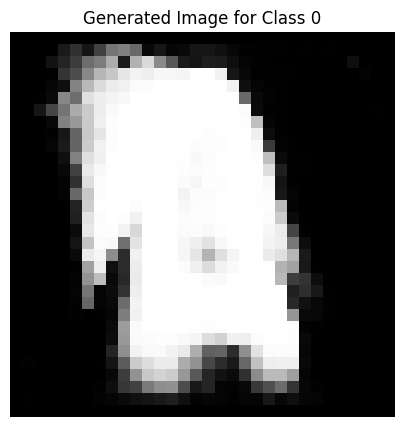

Epoch [8/100], D_loss: -11.164436340332031, G_loss: -0.12641295790672302


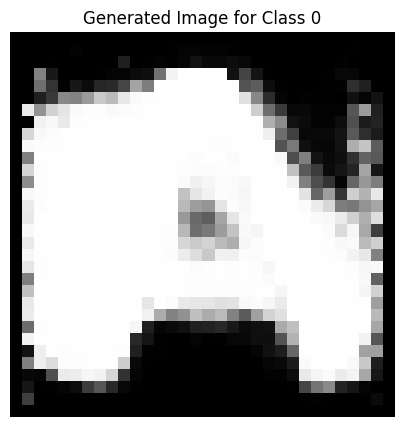

Epoch [9/100], D_loss: -12.422784805297852, G_loss: 2.1389365196228027


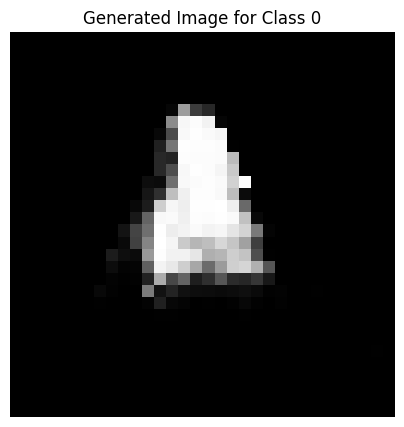

Epoch [10/100], D_loss: -10.125831604003906, G_loss: 5.965116500854492


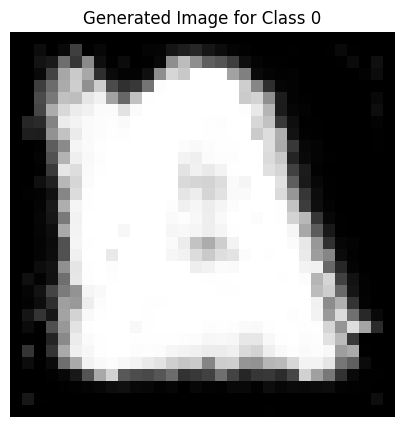

Epoch [11/100], D_loss: -15.830864906311035, G_loss: 10.236750602722168


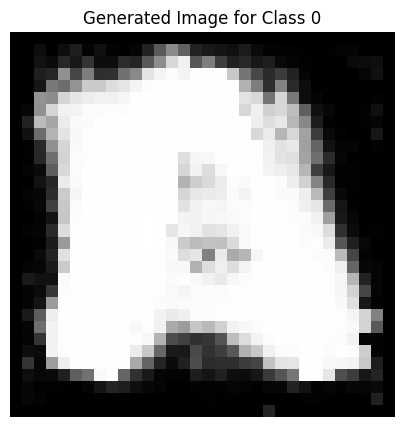

Epoch [12/100], D_loss: -14.40422248840332, G_loss: 12.843206405639648


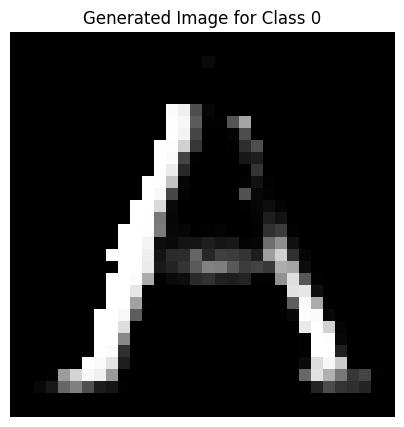

Epoch [13/100], D_loss: -14.73054027557373, G_loss: 12.841144561767578


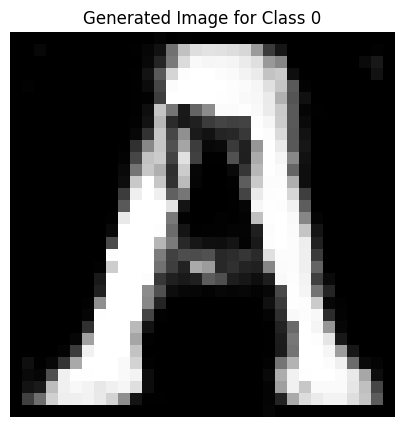

Epoch [14/100], D_loss: -13.458860397338867, G_loss: 13.776554107666016


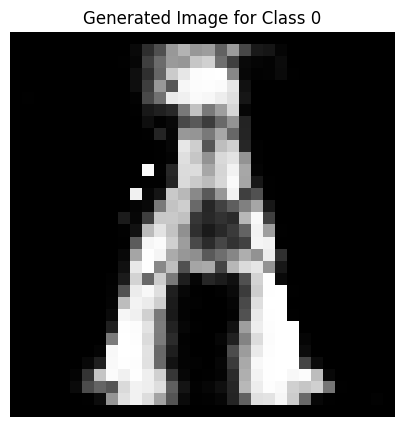

Epoch [15/100], D_loss: -11.79934024810791, G_loss: 10.420816421508789


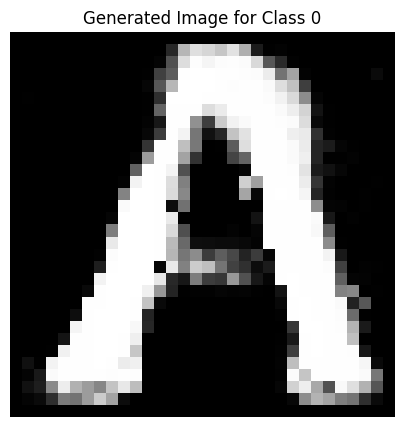

Epoch [16/100], D_loss: -11.398336410522461, G_loss: 12.875904083251953


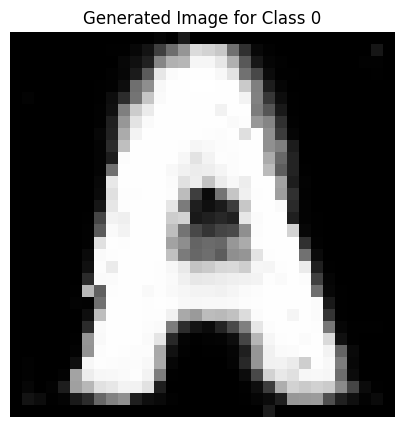

Epoch [17/100], D_loss: -10.724089622497559, G_loss: 13.950196266174316


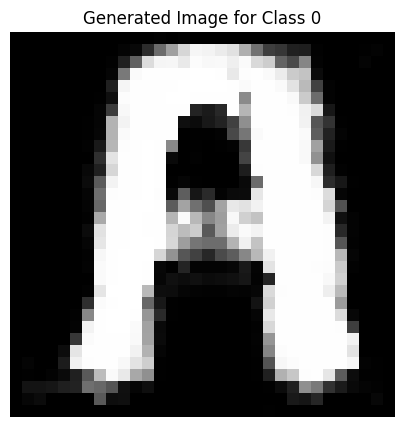

Epoch [18/100], D_loss: -13.27267074584961, G_loss: 13.42013168334961


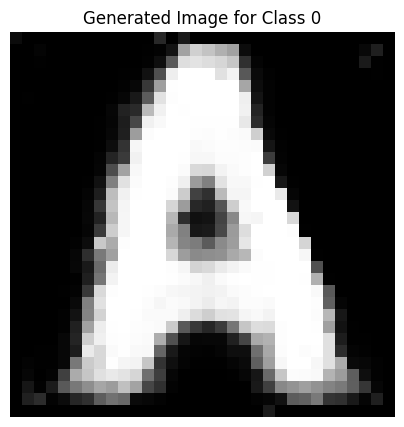

Epoch [19/100], D_loss: -14.449376106262207, G_loss: 16.92516326904297


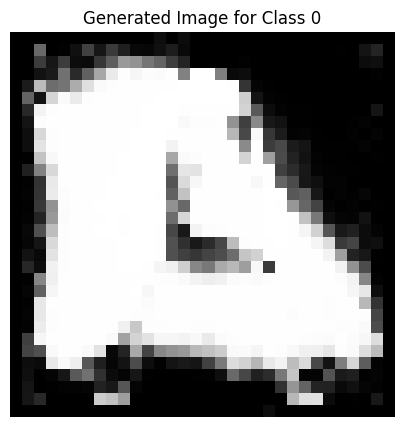

Epoch [20/100], D_loss: -10.156078338623047, G_loss: 14.012508392333984


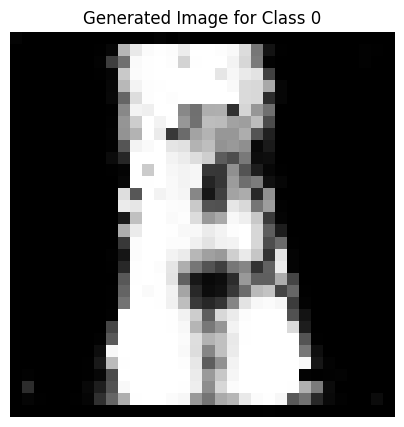

Epoch [21/100], D_loss: -9.880596160888672, G_loss: 14.149913787841797


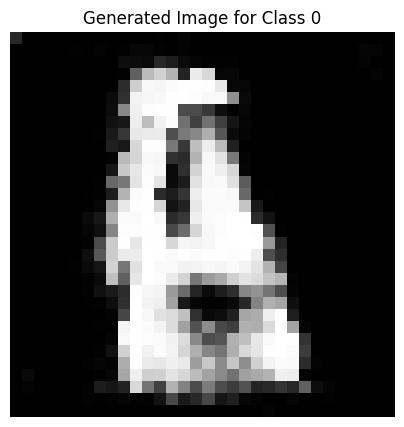

Epoch [22/100], D_loss: -12.739959716796875, G_loss: 12.132892608642578


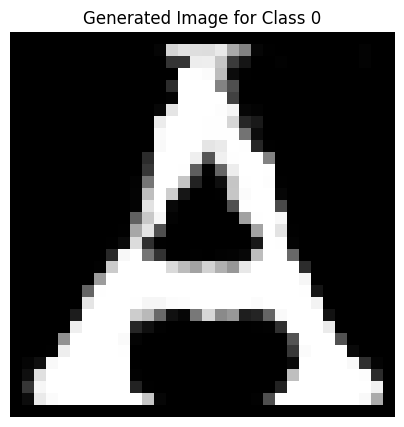

Epoch [23/100], D_loss: -10.675705909729004, G_loss: 12.065568923950195


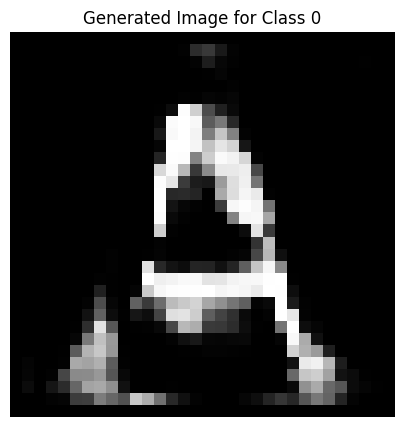

Epoch [24/100], D_loss: -12.72864055633545, G_loss: 6.942201614379883


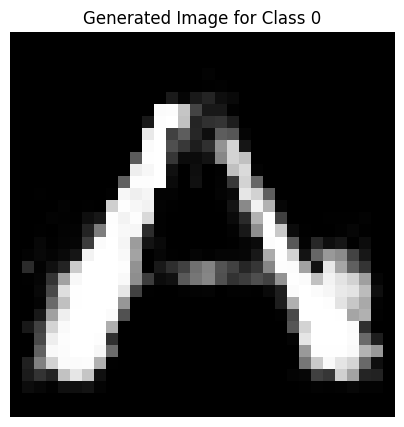

Epoch [25/100], D_loss: -7.1431403160095215, G_loss: 8.445149421691895


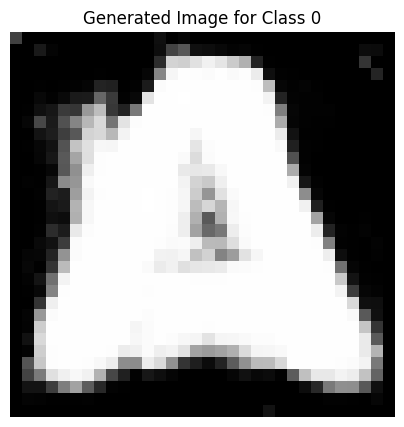

Epoch [26/100], D_loss: -9.534514427185059, G_loss: 7.847499847412109


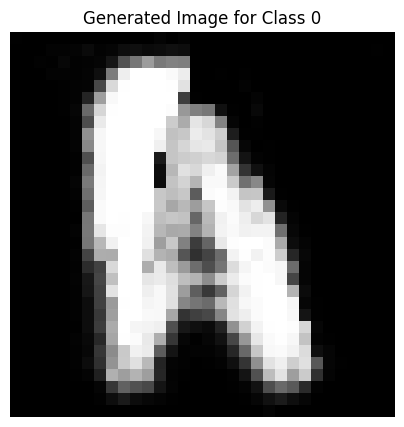

Epoch [27/100], D_loss: -6.894896984100342, G_loss: 9.721216201782227


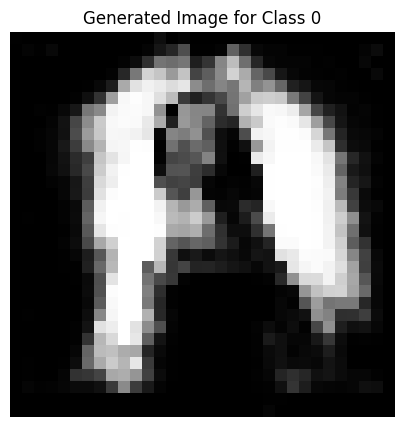

Epoch [28/100], D_loss: -10.199140548706055, G_loss: 11.163200378417969


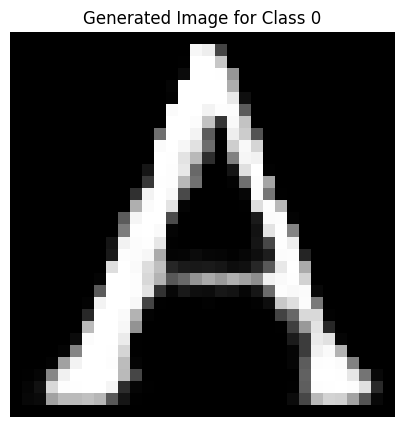

Epoch [29/100], D_loss: -8.395194053649902, G_loss: 11.421195030212402


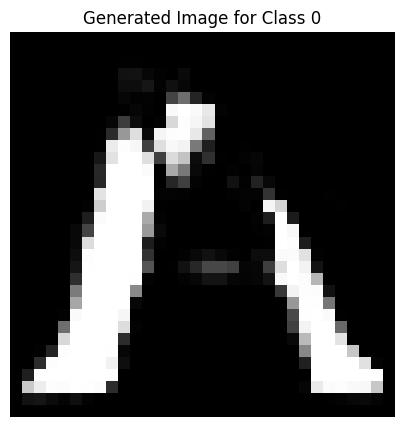

Epoch [30/100], D_loss: -9.34058666229248, G_loss: 9.451315879821777


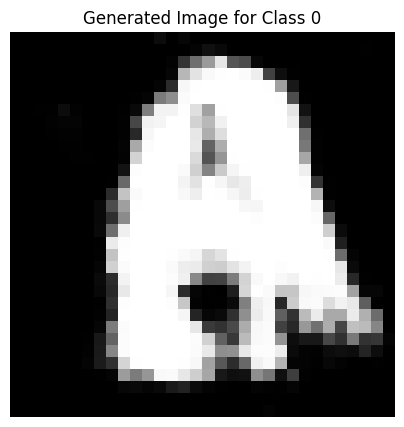

Epoch [31/100], D_loss: -9.807788848876953, G_loss: 9.522577285766602


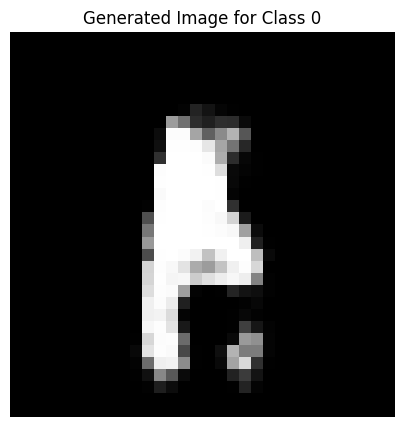

Epoch [32/100], D_loss: -6.260544300079346, G_loss: 12.169925689697266


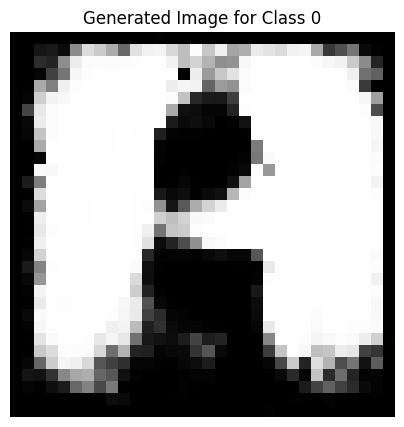

Epoch [33/100], D_loss: -7.42596435546875, G_loss: 9.728937149047852


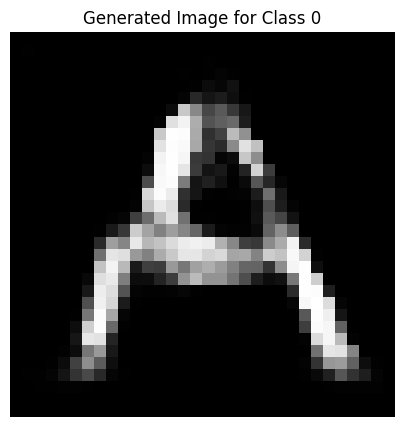

Epoch [34/100], D_loss: -7.187049865722656, G_loss: 11.178166389465332


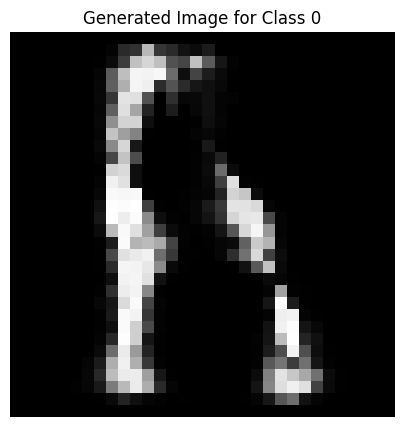

Epoch [35/100], D_loss: -6.2073822021484375, G_loss: 10.556055068969727


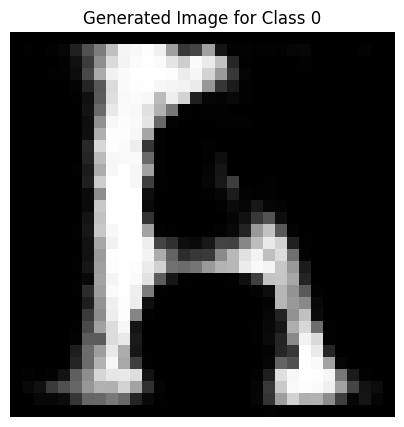

Epoch [36/100], D_loss: -7.739383220672607, G_loss: 11.081161499023438


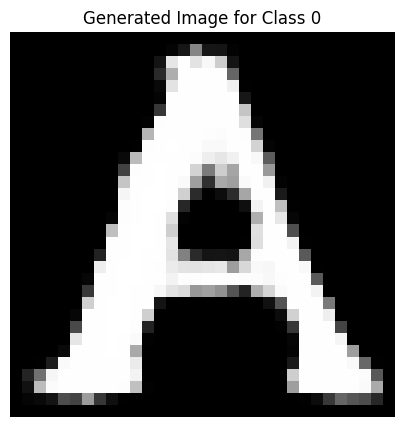

Epoch [37/100], D_loss: -9.758997917175293, G_loss: 11.203943252563477


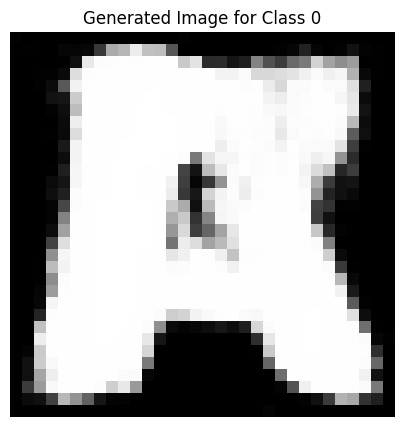

Epoch [38/100], D_loss: -6.519824028015137, G_loss: 11.02376937866211


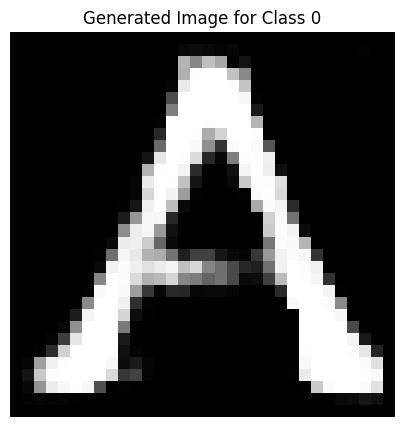

Epoch [39/100], D_loss: -7.109084129333496, G_loss: 12.469270706176758


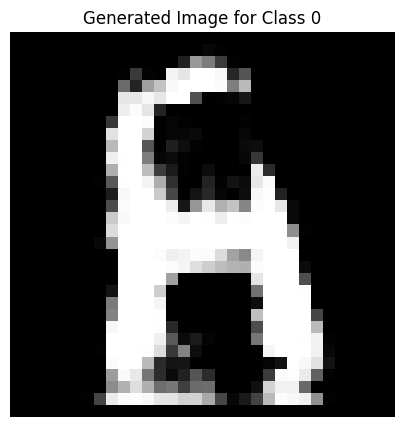

Epoch [40/100], D_loss: -6.903831958770752, G_loss: 10.476691246032715


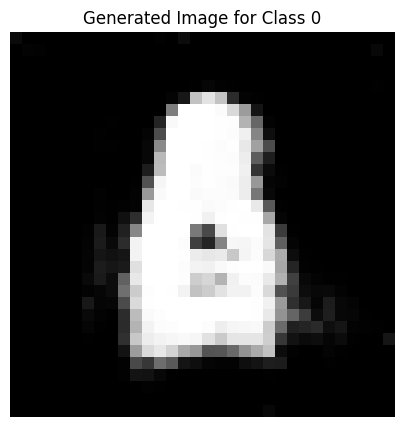

Epoch [41/100], D_loss: -7.765774726867676, G_loss: 10.711149215698242


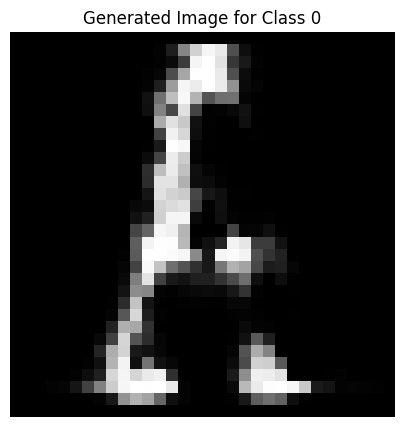

Epoch [42/100], D_loss: -6.632644176483154, G_loss: 10.869647979736328


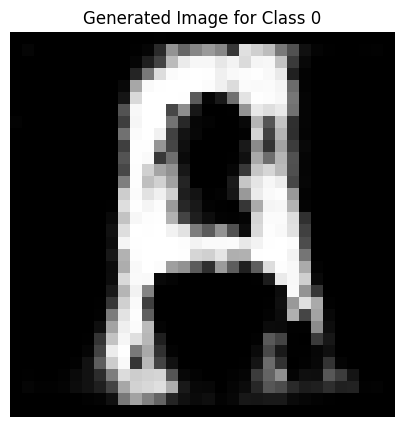

Epoch [43/100], D_loss: -7.5074076652526855, G_loss: 10.874988555908203


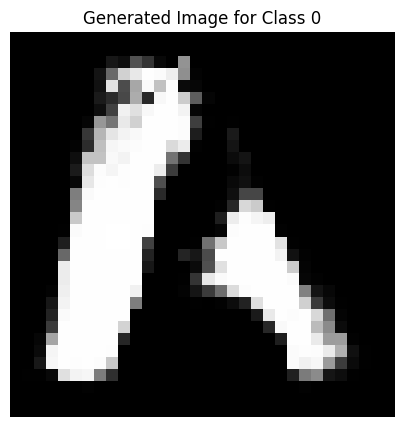

Epoch [44/100], D_loss: -9.99392318725586, G_loss: 10.066941261291504


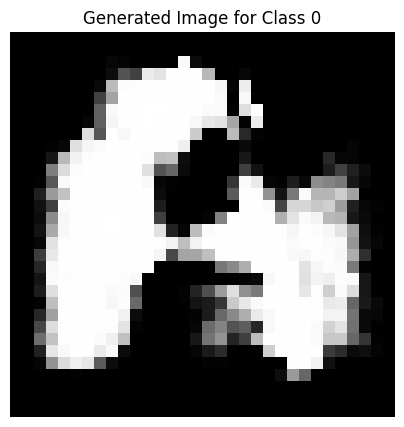

Epoch [45/100], D_loss: -7.802836894989014, G_loss: 9.550365447998047


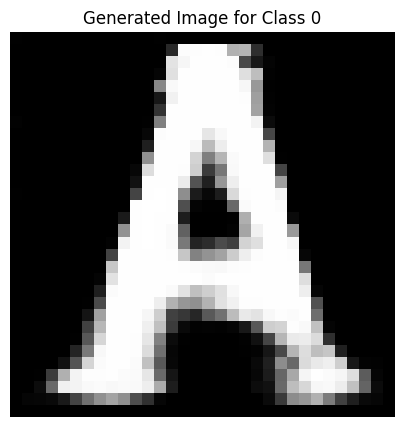

Epoch [46/100], D_loss: -7.595643043518066, G_loss: 9.340606689453125


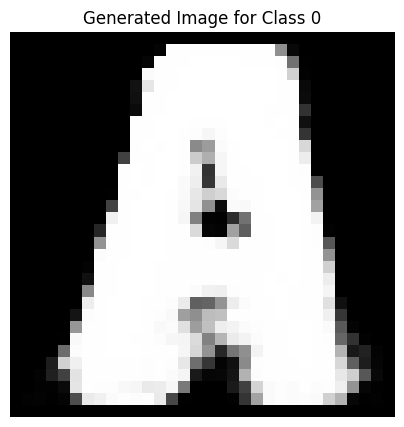

Epoch [47/100], D_loss: -9.264779090881348, G_loss: 10.895130157470703


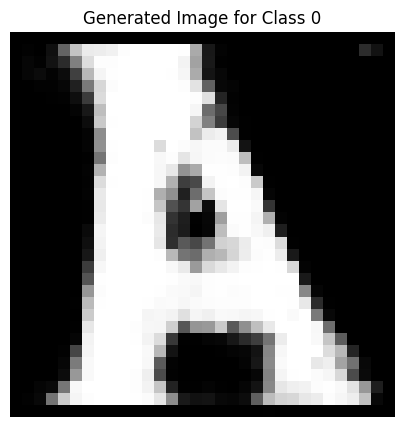

Epoch [48/100], D_loss: -8.452567100524902, G_loss: 9.079488754272461


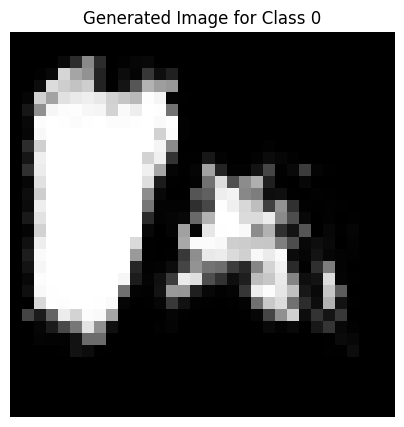

Epoch [49/100], D_loss: -6.337007999420166, G_loss: 6.654901504516602


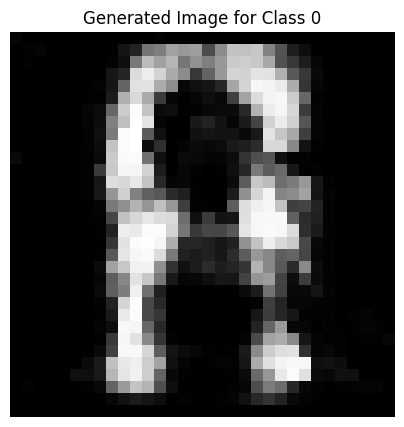

Epoch [50/100], D_loss: -6.59903621673584, G_loss: 8.241986274719238


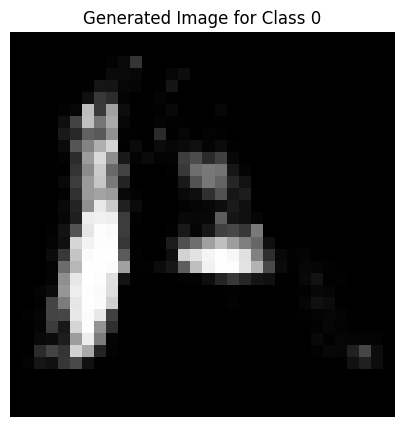

Epoch [51/100], D_loss: -6.082134246826172, G_loss: 11.127497673034668


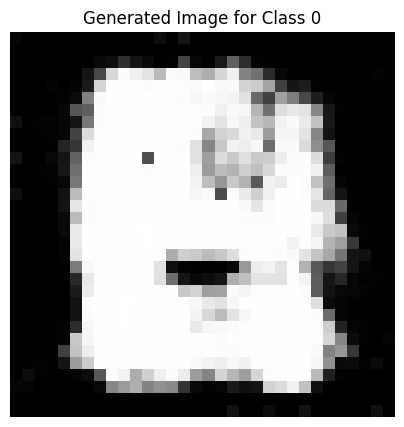

Epoch [52/100], D_loss: -5.453207015991211, G_loss: 8.143024444580078


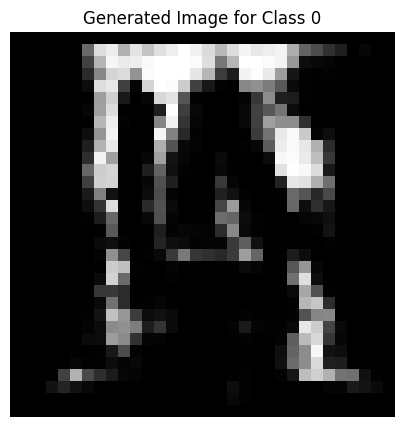

Epoch [53/100], D_loss: -6.9982404708862305, G_loss: 7.089038848876953


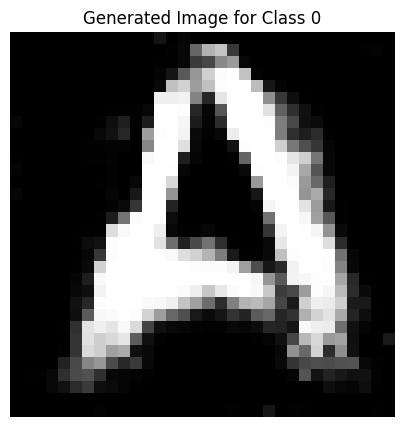

Epoch [54/100], D_loss: -7.829961776733398, G_loss: 9.133951187133789


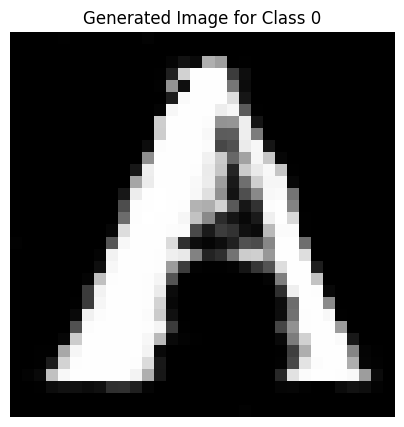

Epoch [55/100], D_loss: -5.26150369644165, G_loss: 9.20555305480957


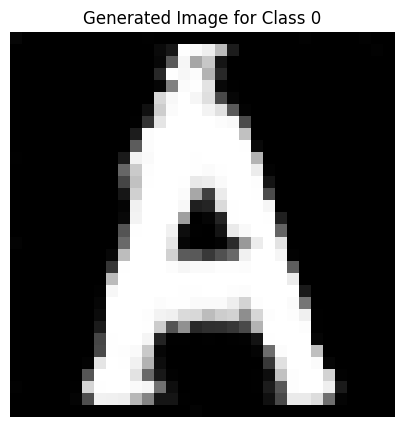

Epoch [56/100], D_loss: -7.833376884460449, G_loss: 6.950593948364258


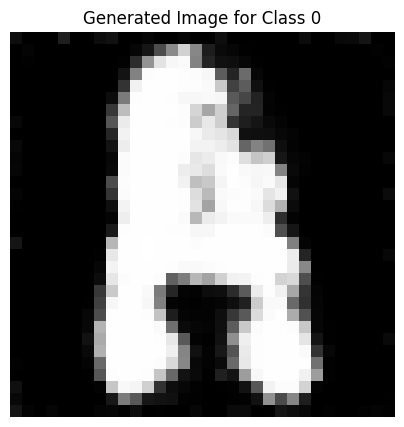

Epoch [57/100], D_loss: -4.653290748596191, G_loss: 10.697549819946289


KeyboardInterrupt: 

In [10]:
# Hyperparameters
z_dim = 100
num_classes = 26  # For uppercase alphabets
img_size = 32  # Assuming 32x32 images
batch_size = 64
lr = 0.0002
lambda_gp = 10  # Gradient penalty weight
n_critic = 5  # Number of discriminator updates per generator update
epochs = 100
dataset = NPZDataset(npz_file, transform, 0, 10000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models and optimizers
generator = Generator(z_dim, num_classes, img_size).cuda()
discriminator = Discriminator(img_size).cuda()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))

# Training
for epoch in range(epochs):
    for i, (real_imgs, labels) in enumerate(dataloader):
        # Fix real_imgs shape

        real_imgs = real_imgs.permute(0, 2, 1, 3).cuda()
        labels = labels.cuda()
        batch_size = labels.shape[0]
        # Generate one-hot vectors for labels
        z_c = torch.zeros(batch_size, num_classes).cuda()
        z_c[torch.arange(batch_size), labels] = 1

        # Train Discriminator
        z_s = torch.randn(batch_size, z_dim).cuda()
        fake_imgs = generator(z_s, z_c)
        real_validity = discriminator(real_imgs)
        fake_validity = discriminator(fake_imgs.detach())  # Detach to avoid affecting generator
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs, fake_imgs)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator every n_critic steps
        if i % n_critic == 0:
            z_s = torch.randn(batch_size, z_dim).cuda()  # Regenerate z_s
            fake_imgs = generator(z_s, z_c)  # Generate new fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            optimizer_G.zero_grad()
            g_loss.backward()  # No retain_graph needed
            optimizer_G.step()

    displayGeneratedImage(class_index=0, generator=generator, z_dim=z_dim, num_classes=num_classes, device='cuda')
    print(f"Epoch [{epoch+1}/{epochs}], D_loss: {d_loss.item()}, G_loss: {g_loss.item()}")